# DL-Ops Assignment 3: Tiny-Imagenet

## Checking Avilable GPU

In [28]:
!nvidia-smi

ValueError: filedescriptor out of range in select()

## Importing requirements

In [ ]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy
from tqdm.auto import tqdm

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

## device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Dataset with pytorch

### Downloading Dataset

In [ ]:
from pathlib import Path

url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
# create a Path object with the path to the file
path = Path('tiny-imagenet-200.zip')

if path.is_file() == False:
  print("Downloding dataset...")
  !wget {url}
  print("Extracting 'tiny-imagenet-200.zip'...")
  !unzip 'tiny-imagenet-200.zip'
else:
  print("Skipping Downloding...")

Skipping Downloding...


In [ ]:
print("Processing the Raw Extracted Data")
import io
import glob
import os
from shutil import move
from os.path import join
from os import rmdir

target_folder = './tiny-imagenet-200/val/'

val_dict = {}
try:
  with open(target_folder + 'val_annotations.txt', 'r') as f:
      for line in f.readlines():
          split_line = line.split('\t')
          val_dict[split_line[0]] = split_line[1]
          
  paths = glob.glob(target_folder + 'images/*')
  paths[0].split('/')[-1]
  for path in paths:
      file = path.split('/')[-1]
      folder = val_dict[file]
      if not os.path.exists(target_folder + str(folder)):
          os.mkdir(target_folder + str(folder))
          
  for path in paths:
      file = path.split('/')[-1]
      folder = val_dict[file]
      dest = target_folder + str(folder) + '/' + str(file)
      move(path, dest)
      
  os.remove('./tiny-imagenet-200/val/val_annotations.txt')
  rmdir('./tiny-imagenet-200/val/images')
except:
  print("Processing Done Before or unable to process")
print("Processing Step Done")

Processing the Raw Extracted Data
Processing Done Before or unable to process
Processing Step Done


In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
        )

# define transforms
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
])


train_dataset = torchvision.datasets.ImageFolder(
    root='tiny-imagenet-200/train',
    transform=transform,
)

test_dataset = torchvision.datasets.ImageFolder(
    root='tiny-imagenet-200/val',
    transform=transform,
)
train_dataset, test_dataset


(Dataset ImageFolder
     Number of datapoints: 100000
     Root location: tiny-imagenet-200/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ),
 Dataset ImageFolder
     Number of datapoints: 10000
     Root location: tiny-imagenet-200/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

### Vis. dataset (train dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


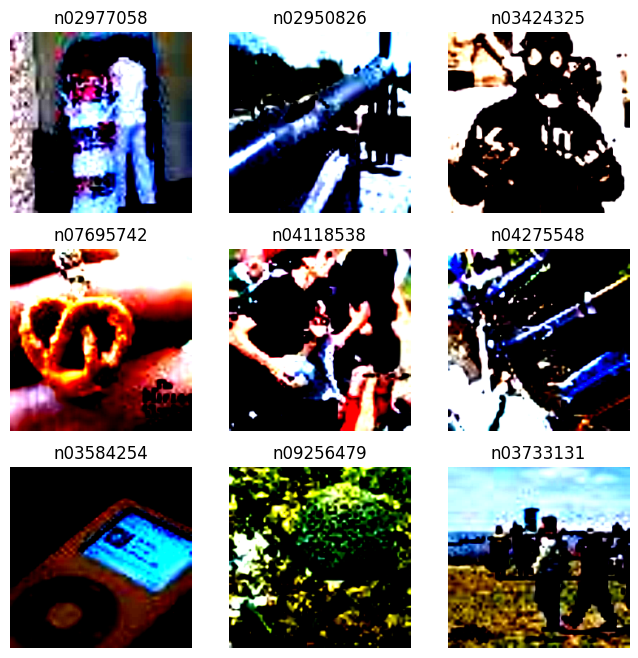

In [ ]:
# randomly ploting image samples from the grayscale dataset
labels_map = train_dataset.class_to_idx  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

### Converting dataset to dataloader

In [ ]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 3125
Numbers of Batches in Test Dataloader: 313


## Making CSVs for application of triplet loss

In [ ]:
import os
import pandas as pd
from pathlib import Path

In [ ]:
train_data_path = Path('tiny-imagenet-200/train/')
test_data_path = Path('tiny-imagenet-200/val/')
train_data_path,test_data_path

(PosixPath('tiny-imagenet-200/train'), PosixPath('tiny-imagenet-200/val'))

In [ ]:
train_data_path_list = list(train_data_path.glob("*/*/*.JPEG"))
test_data_path_list = list(test_data_path.glob("*/*.JPEG"))

In [ ]:
image_name = []
class_name = []
for i in train_data_path_list:
    x = str(i).split("/")
    # print(x)
    image_name.append(x[4])
    class_name.append(x[2])

data_dict = {'image_name':image_name , 'class_name': class_name}
     
df = pd.DataFrame(data_dict)
df.to_csv('train_data.csv',index=False)

In [ ]:
image_name = []
class_name = []
for i in test_data_path_list:
    x = str(i).split("/")
    # print(x)
    image_name.append(x[3])
    class_name.append(x[2])

data_dict = {'image_name':image_name , 'class_name': class_name}
     
df = pd.DataFrame(data_dict)
df.to_csv('test_data.csv',index=False)

In [ ]:
import random
train_data= pd.read_csv('train_data.csv')
train_data_path = './tiny-imagenet-200/train/'

In [ ]:
from PIL import Image

class TinyImageNetDataset_Triplet():
    def __init__(self, df, path, train=True, transform=None):
        # print(df.head())
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path = path
        if self.is_train:
            self.images = df.iloc[:, 0].values
            self.labels = df.iloc[:, 1].values
            self.index = df.index.values 
    def __len__(self):
        return len(self.images)
    def __getitem__(self, item):
        # print("anchor_image_name:",self.images[item])
        anchor_image_name = self.images[item]
        # print("label_item:",self.labels[item])
        anchor_image_path = self.path + '/' + self.labels[item] + '/images/' + anchor_image_name
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert('RGB')
        if self.is_train:
            anchor_label = self.labels[item]
            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
            positive_item = random.choice(positive_list)
            positive_image_name = self.images[positive_item]
            positive_image_path = self.path + '/' + self.labels[positive_item] + '/images/' + positive_image_name
            positive_img = Image.open(positive_image_path).convert('RGB')
            #positive_img = self.images[positive_item].reshape(28, 28, 1)
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_image_name = self.images[negative_item]
            negative_image_path = self.path + '/' + self.labels[negative_item] + '/images/' + negative_image_name
            negative_img = Image.open(negative_image_path).convert('RGB')
            #negative_img = self.images[negative_item].reshape(28, 28, 1)
            if self.transform!=None:
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)                   
                negative_img = self.transform(negative_img)
        return anchor_img, positive_img, negative_img, anchor_label

In [29]:
from torch.utils.data import Dataset

class TinyImageNetDataset_Triplet_for_loss_getting_3_elements(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [ ]:
def get_train_dataset(IMAGE_SIZE:int =96):
    train_dataset = TinyImageNetDataset_Triplet(
        train_data,
        path=train_data_path,
        train=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))
            ])
        )
    return train_dataset

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1:torch.Tensor, x2:torch.Tensor):
        ''' calculate euclidean distance between two tensors '''
        return (x2-x1).pow(2).sum(1).pow(0.5)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [ ]:
IMAGE_SIZE = 224
NUM_WORKERS = os.cpu_count()
PIN_MEM = True
BATCH_SIZE = 32

train_dataset = get_train_dataset(IMAGE_SIZE = IMAGE_SIZE)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEM
)
print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")

Numbers of Batches in Train Dataloader: 3125


## Model Definition

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super().__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, 10)
        self.Triplet_Loss = nn.Sequential(nn.Linear(10,num_classes))
        
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.Triplet_Loss(x) # triplet loss
        return x

def ResNet18_cifar(num_classes=10):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=num_classes)

In [ ]:
model_resnet_triplet_loss = ResNet18_cifar(num_classes=2).to(device=device)

## Training

In [ ]:
LEARNING_RATE = 1e-3
Optimizer = torch.optim.Adam(model_resnet_triplet_loss.parameters(),lr = LEARNING_RATE)
criterion = TripletLoss().to(device=device)

In [24]:
# next(iter(train_dataloader))

In [25]:
EPOCHS  = 5
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dataloader, desc="Training", leave=True)):
        
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        Optimizer.zero_grad()
        anchor_out = model_resnet_triplet_loss(anchor_img)
        positive_out = model_resnet_triplet_loss(positive_img)
        negative_out = model_resnet_triplet_loss(negative_img)
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        Optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 1/5 — Loss: 0.8899


Training:   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 2/5 — Loss: 0.8478


Training:   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 3/5 — Loss: 0.8146


Training:   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 4/5 — Loss: 0.7932


Training:   0%|          | 0/3125 [00:01<?, ?it/s]

Epoch: 5/5 — Loss: 0.7658
